# Blai Ras Jimenez

## Assignment 2: Factorization Machines

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input\movielens-fds\movielens-fds.zip
kaggle/input\movielens-fds\sample_submission.csv
kaggle/input\movielens-fds\test.csv
kaggle/input\movielens-fds\training.csv


In [49]:
def evaluate(predict_f,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)


def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.05)),
                                   replace=False)
    df['for_testing'] = False
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [50]:
# Discount Cumulative Gain function
def ndcg(y_pred, y_true,k):
    
    # First sort my predicted scores
    sort = np.argsort(y_pred)[::-1]
    
    # Take k elements of my array
    y_true = np.take(y_true, sort[:k])
    
    # Compute the G: gains
    G = 2 ** y_true - 1
    
    # Compute the D: discounts
    D = np.log2(np.arange(2, G.size + 2))
    
    # Finally compute the DCG
    dcg = np.sum(G/D)
    
    return dcg

In [57]:
df = pd.read_csv('kaggle/input/movielens-fds/training.csv',index_col=0)

In [58]:
df.shape

(945180, 5)

In [59]:
# If you wish to do an small, quick train, re-sample the original dataset with less ratings.
df = df.sample(100000)

In [60]:
df_test = pd.read_csv('kaggle/input/movielens-fds/test.csv',index_col=0)

In [27]:
df_test.shape

(848600, 4)

## Feature encoding

I tried two different latent vectors (features) for my Factorization Machine approach: the genre and the releasing year of the movie.

### Genre

In order to encode this feature inside my recommender system I decided to categorize it using a one-hot encoding philosophy: multiple binary variables (dummy variables). 

The tricky part was slicing the "genre" column, encoded with the character " | " as separator. The way I dealt with this problem is using the sklearn Multi Label Binarizer. 

First, I get each genre of each movie splitting its text by "|". Then, I pass this Pandas series to the MLB, which is able to create multiple binary variables with indexing using its method $\texttt{fit_transform}$. Therefore, it's easy to create a Pandas dataframe containing each dummy variable from it. 

At this point, all that's left is joining this one-hot encoding dataframe to the original dataframe. As a consequence, we can drop the genre original column and the one we created when slicing.

There are movies with no genre listed. I decided to keep them under the column "(no genres listed)". There are also movies with the genre "IMAX" which is not really a "genre", but I keep them either way.

I've implemented this approach in the function below:

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer

def genre_categorical(df):
    
    df['gen_list'] = df['genre'].str.split('|')

    ## Column containing a genre list for each movie
    serieList = pd.Series(df["gen_list"])

    mlb = MultiLabelBinarizer()

    # Create a new dataframe of the genres from the list for each row 
    one_hot_genres = pd.DataFrame(mlb.fit_transform(serieList),columns=mlb.classes_,index=serieList.index)
    
    # Removing unwanted columns
    df = df.drop(["gen_list","title","genre"],axis=1)
    
    # Merging
    return pd.merge(df,one_hot_genres, left_index=True, right_index=True)

### Year

I also tried to aisle the year of each movie and work with it as a feature. The way the year is encoded is as text next to the movie title. Therefore, I used regex to extract it and save it to a new column, "year". 

In order to deal with the movies that have no year registered, I transform the type of this "year" column to datetime, getting "NaN's" when the year is invalid. I replaced this NaN's with the mean year of the overall movies.

As a result, I get a lot of different years. It's not a good idea to binary categorize each year, because as a result I would get like 40 different columns if we count the binarized genres.

Therefore, I splitted this "year" column into 3 new ones by its quantiles: "year_old" contains all the years from the oldest to the 0.25 quantile, "year_mid" from 0.25 to 0.75, and "year_new" from 0.75 to the newest year. 
In order to binarize it I just use the $\texttt{pd.get_dummies}$ Pandas method.

I coded this transformation in the function below:

In [62]:
def categorical_year(df):
    # Year regex extraction
    df['year'] = df.title.str.extract("\((\d{4})\)", expand=True)
    # Year to Year datatime in order to get NaN's
    df.year = pd.to_datetime(df.year, format='%Y')
    df.year = df.year.dt.year
    
    # Replace NaN's with the overall mean
    df["year"] = df["year"].fillna(int(np.nanmean(df.year.unique())))
    
    # Year into 3-way categorization by quantiles
    df['year'] = pd.cut(df.year,
                     bins=[df.year.quantile(0), df.year.quantile(0.25), df.year.quantile(0.75), df.year.quantile(1)],
                     labels=["old", "mid", "new"])
    # Year binarization
    return pd.get_dummies(df,columns=["year"])

Nevertheless, after various tests with this year one-hot encoding, **I decided not to add this feature**, due to poor performance in terms of RMSE. Probably, there are too many columns (25) if we categorize the genre and the year, and the model starts to overfit, as we can see below (k=10, lambda=0.03, lr=0.01, 60 iterations):

<img src="TrainWithYearPlot.PNG">

In consequence, I decided to only add the genre as feature.

In [63]:
# Transform my datasets with this genre one-hot encoding
df = genre_categorical(df)
df_test = genre_categorical(df_test)

In [64]:
df_test.head()

,user_id,movie_id,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1762,307,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1762,67534,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1762,2317,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1762,94011,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1762,164725,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data treatment

This function below splits my dataframe into test/validation sets and also changes the column data type for "user_id" and "movie_id" so the model do not treat them as integers.

In [65]:
def data_split(df,df_test):
    grouped = df.groupby('user_id', group_keys=False).apply(assign_to_set)
    df_train = df[grouped.for_testing == False]
    df_val   = df[grouped.for_testing == True]
    
    val = df_val.copy()
    train = df_train.copy()
    test = df_test.copy()
    
    y_train = train['rating']
    train.drop(['rating'], axis=1, inplace=True)

    train['user_id'] = train['user_id'].astype('str')
    train['movie_id'] = train['movie_id'].astype('str')

    y_val = val["rating"]
    val.drop(['rating'], axis=1, inplace=True)
    val['user_id'] = val['user_id'].astype('str')
    val['movie_id'] = val['movie_id'].astype('str')

    test['user_id'] = test['user_id'].astype('str')
    test['movie_id'] = test['movie_id'].astype('str')
    
    return train,y_train,val,y_val,test

In [66]:
train,y_train,val,y_val,test = data_split(df,df_test)

In [67]:
print("Train size:",train.shape,
      "\nVal size:",val.shape,
      "\nTest size:",test.shape)

Train size: (88984, 22) 
Val size: (11016, 22) 
Test size: (848600, 22)


## Model

Below is the modified base code in order to perform the Factorization Machine model. Long story short, I changed the way we index each movie/user with the $\texttt{getIdx}$ function and I perform the training inside the $\texttt{sgd}$ function. 

In [68]:
from scipy import sparse

class RecSys_FM():
    """ Collaborative filtering using a custom sim(u,u'). """

    def __init__(self,df_train,df_val,num_components=10,k=10):
        """ Constructor """
        self.df_train = df_train
        self.df_val = df_val
        self.num_components=num_components
        self.k = k
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        i = 0
        cols = {}
        for col in df_train.columns:
            cols[col] = i
            i += 1

        idxs = {}
        nonZero = 0
        for col in df_train.columns:
            if col == "user_id" or col == "movie_id":
                idxs[cols[col]] = {}
                colset = set(df_train[col])
                for movieUserCol in colset:
                    idxs[cols[col]][movieUserCol] = nonZero
                    nonZero += 1
            else:
                idxs[cols[col]] = nonZero
                nonZero += 1
        self.idxs = idxs
        self.nonZero = nonZero
        
        # initialize latent vectors
        self.w0 = np.mean(df_val)
        self.w1 = np.zeros(self.nonZero)
        self.v = np.random.normal(scale=0.1,size=(self.nonZero, self.k))
        
        
    def getIdx(self, vec):
        idx = []
        for col in range(len(vec)):
            if isinstance(self.idxs[col], int) or isinstance(self.idxs[col], float):
                idx.append((self.idxs[col], vec[col]))
            else:
                try:
                    idx.append((self.idxs[col][vec[col]], 1.))
                except:
                    idx.append((0., 0.))
        return idx
        
    def __sdg__(self):
        df_train = np.array(self.df_train)
        df_val = np.array(self.df_val)
        learning_rate = self.learning_rate
        lmbda = self.lmbda
        w0 = self.w0
        w1 = self.w1
        v = self.v
        nonZero = self.nonZero

        m = df_train.shape[0]
        n = df_train.shape[1]
        
        #SGD
        for epoch in range(self.n_epochs):
            start_time = time.perf_counter()
            
            predictions = []
            for i in range(m):
                x = df_train[i, :]
                tempVals = self.getIdx(x)
                idx = {}
                firstSum = 0
                secondSum = 0
                thirdSum = np.zeros(self.k)

                for col in range(n):
                    index, value = tempVals[col]
                    idx[index] = value
                    firstSum += w1[index] * value

                for j in range(self.k):
                    jSum1 = 0.0
                    jSum2 = 0.0
                    for col in range(n):
                        index, value = tempVals[col]
                        tmp = v[index, j] * value
                        jSum1 += tmp
                        jSum2 += tmp * tmp
                    thirdSum[j] = jSum1
                    secondSum += jSum1 * jSum1 - jSum2

                yhat = w0 + firstSum + 0.5 * secondSum
                yhat = max(1., yhat)
                yhat = min(5., yhat)
                out = (yhat - df_val[i])

                #Update Rule w0
                w0 = w0 - (learning_rate * out) - learning_rate * w0 * lmbda

                for col in range(n):
                    index, value = tempVals[col]
                    tmp = learning_rate * value * out
                    w1[index] -= (tmp + (learning_rate*lmbda)*w1[index])
                    for j in range(self.k):
                        v[index, j] -= (tmp * (thirdSum[j] - v[index, j] * value) + (learning_rate*lmbda)*v[index, j])
            
            self.train_rmse.append(compute_rmse(yhat,df_val))
            self.test_rmse.append(compute_rmse(yhat,self.y_val))
            
            print("Epoch",epoch,"lasted:",time.perf_counter()-start_time)
            print('\tTrain RMSE: %s' % self.train_rmse[-1])
            print('\tTest RMSE: %s' % self.test_rmse[-1])

        self.w0 = w0
        self.w1 = w1
        self.v = v
                                      
        if(self.verbose):
            self.__plot_learning_curves__()
        
    def fit(self,y_val,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        self.y_val = y_val
        self.n_epochs = n_epochs
        self.train_rmse =[]
        self.test_rmse = []
        
        self.__sdg__()
        return
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, df, verbose=True):

        df = np.array(df)
        
        w0 = self.w0
        w1 = self.w1
        v = self.v
        nonZero = self.nonZero

        m = df.shape[0]
        n = df.shape[1]
        
        predictions = []
        for i in range(m):
            x = df[i, :]
            tempVals = self.getIdx(x)
            idx = {}
            firstSum = 0
            secondSum = 0
            thirdSum = np.zeros(self.k)

            for col in range(n):
                index, value = tempVals[col]
                idx[index] = value
                index = int(index)
                firstSum += w1[index] * value

            for j in range(self.k):
                jSum1 = 0
                jSum2 = 0
                for col in range(n):
                    index, value = tempVals[col]
                    index = int(index)
                    tmp = v[index, j] * value
                    jSum1 += tmp
                    jSum2 += tmp * tmp
                thirdSum[j] = jSum1
                secondSum += jSum1 * jSum1 - jSum2

            yhat = w0 + firstSum + 0.5 * secondSum
            yhat = max(1., yhat)
            yhat = min(5., yhat)
            predictions.append(yhat)

        return predictions
        

Epoch 0 lasted: 50.78183259999969
	Train RMSE: 1.256138521470077
	Test RMSE: 1.2469393908181268
Epoch 1 lasted: 49.8561138999994
	Train RMSE: 1.2922196725917083
	Test RMSE: 1.27945814289381
Epoch 2 lasted: 49.421002600000065
	Train RMSE: 1.250929302854489
	Test RMSE: 1.2422839402487964
Epoch 3 lasted: 51.11197979999997
	Train RMSE: 1.189462644369291
	Test RMSE: 1.188335396016673
Epoch 4 lasted: 51.51828690000002
	Train RMSE: 1.1508256556399155
	Test RMSE: 1.1557449548411467
Epoch 5 lasted: 50.379704400000264
	Train RMSE: 1.1242775923938868
	Test RMSE: 1.1343614536513607
Epoch 6 lasted: 48.76578840000002
	Train RMSE: 1.1028751867893418
	Test RMSE: 1.118177359099356
Epoch 7 lasted: 48.76347859999987
	Train RMSE: 1.0879856211141123
	Test RMSE: 1.1079813339017468
Epoch 8 lasted: 49.46762269999999
	Train RMSE: 1.0788139619152257
	Test RMSE: 1.1026353532477322
Epoch 9 lasted: 49.765323499999795
	Train RMSE: 1.0737578404491834
	Test RMSE: 1.10039777566761


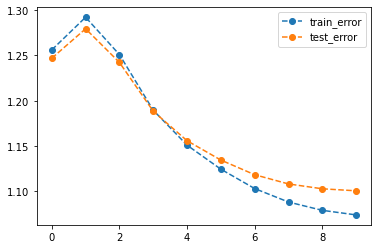

In [76]:
f = RecSys_FM(train,y_train,num_components=10,k=10)
f.fit(y_val,n_epochs=10,learning_rate=0.05,lmbda=0.05)

In [77]:
y_pred = f.predict(val)

## Evaluation

### Basic RMSE

In [78]:
print('RMSE for Collaborative Recomender: %s' % compute_rmse(y_val,y_pred))

RMSE for Collaborative Recomender: 1.1180573813554475


### NDCG 

I also implemented a Normalized Discount Cumulative Gain evaluation function (above the notebook). My initial goal was to use it alongside my SGD as loss function, but I could not made it work due to lack of time (specially for others deliveries we had this week) and maybe lack of knowledge. 

What I did was use it as it is, after the training of my recommender system. I also tried to print it on each epoch, but its value does not change much, of course, specially if you "pick" a few movies (because you're sorting the k=10 movies or so).

\begin{align}
DCG_k = \sum_{i=1}^k \frac{2^{rel_i} - 1}{\log_2{\left(i+1\right)}}
\end{align}

So, I use this evaluation method by first computing the DCG of the best ranking score and then divide it by the ideal DCG, getting a score between 0 and 1.

In [79]:
ndcgTrain = ndcg(y_pred,y_val,10)
possible = ndcg(y_val,y_val,10)
print('NDCG of Validation:',ndcgTrain/possible)

NDCG of Validation: 0.7830070575713997


I did several parameter hypertunning in order to find out the optimal combination, evaluating each training with the methods just described and the Kaggle competition result. Below are a few of the total 21 submissions done:

| K  | Epochs | Learning Rate | Lambda | Train RMSE | Val. RMSE | Time (hours) | Dataset size | Kaggle Score |
|----|--------|---------------|--------|------------|-----------|--------------|--------------|--------------|
| 10 | 60     | 0.01          | 0.03   | 0.46       | 1.06      | ~5           | 101k         | 0.69989      |
| 10 | 60     | 0.01          | 0.01   | 0.41       | 1.06      | ~5           | 101k         | 0.69071      |
| 5  | 66     | 0.01          | 0.03   | 0.42       | 1.08      | ~4           | 101k         | 0.68763      |
| 10 | 80     | 0.01          | 0.03   | -          | -         | ~7           | 201k         | 0.67006      |
| 10 | 100    | 0.01          | 0.03   | -          | 1.06      | ~7           | 101k         | 0.66658      |
| 10 | 70     | 0.001         | 0.003  | 0.75       | 0.98      | ~10          | All          | 0.66382      |
| 10 | 60     | 0.001         | 0.003  | 0.77       | 1.18      | ~10          | All          | 0.55420      |

I got 0.69 just after finishing the code so I went berserk trying to at least get 0.7 but I could not make it. I tried to change the dataset size, increase and decrese the learning rate and lambda and also to increase or decrease the iterations performed, resulting in minor changes of the Kaggle score.

## Submission

Predict with my test set and sort!

In [73]:
testPred=f.predict(test)
df_test["estimated"] = testPred
df_test.sort_values(by='estimated',ascending=False)[['user_id','movie_id']].to_csv('SubmissionBlaiRas.csv',index=None)